In [57]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, Input
from keras import initializers
from keras.optimizers import Adam
import random
import cv2
import os
from glob import glob
from keras import callbacks

In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [133]:
#파라미터
n1,n2,n3 = 128, 64, 3
f1,f2,f3 = 9,3,5
upscale_factor = 3

input_size = 33
output_size = input_size - f1 - f2 - f3 + 3
pad = abs(input_size - output_size) // 2 # 7
stride = 14

batch_size = 128
epochs = 200

#논문과 동일하게 T91 images 데이터셋 사용
path = "/content/drive/MyDrive/T91"
save_path = "/content/drive/MyDrive/SRCNN_200EPOCHS.h5"

(176, 197, 3)


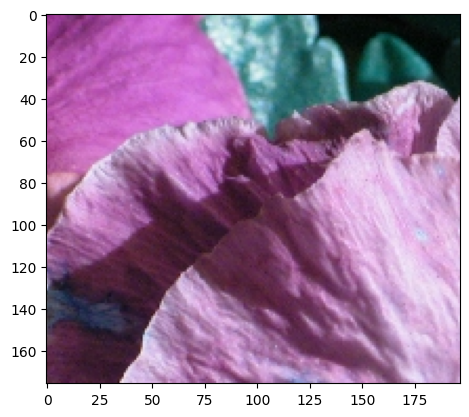

In [134]:
#데이터 로드 및 확인
img_paths = glob(path + '/' + '*.png')

img = cv2.imread(img_paths[0], cv2.COLOR_BGR2RGB)
print(img.shape)
plt.imshow(img)

In [135]:
#저해상도 이미지 생성
sub_lr_imgs = []
sub_hr_imgs = []

for img_path in img_paths:
  img = cv2.imread(img_path, cv2.COLOR_BGR2RGB)

  h = img.shape[0] - np.mod(img.shape[0], upscale_factor)
  w = img.shape[1] - np.mod(img.shape[1], upscale_factor)
  img = img[:h, :w, :]

  # 고해상도 이미지 -> 저해상도 이미지
  label = img.astype('float') / 255
  temp_input = cv2.resize(label, dsize=(0,0), fx = 1/upscale_factor, fy = 1/upscale_factor,
                          interpolation = cv2.INTER_AREA)
  input = cv2.resize(temp_input, dsize=(0,0), fx = upscale_factor, fy = upscale_factor,
                     interpolation = cv2.INTER_CUBIC)

  # 저해상도 이미지와 고해상도 이미지를 각각 Crop해서 input과 label로 맵핑
  for h in range(0, input.shape[0] - input_size + 1, stride):
    for w in range(0, input.shape[1] - input_size + 1, stride):
      sub_lr_img = input[h:h+input_size, w:w+input_size, :]
      sub_hr_img = label[h+pad:h+pad+output_size, w+pad:w+pad+output_size, :]

      sub_lr_imgs.append(sub_lr_img)
      sub_hr_imgs.append(sub_hr_img)

sub_lr_imgs = np.asarray(sub_lr_imgs)
sub_hr_imgs = np.asarray(sub_hr_imgs)

18720


Text(0.5, 1.0, 'hr_img')

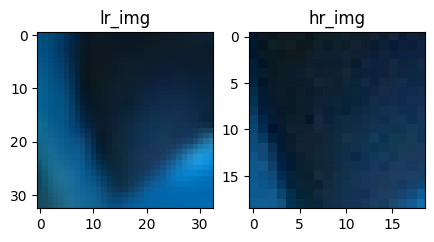

In [136]:
#Crop된 고해상도와 저해상도 이미지쌍 확인
fig, axes = plt.subplots(1,2, figsize = (5,5))
idx = random.randint(0, sub_lr_imgs.shape[0])

axes[0].imshow(sub_lr_imgs[idx])
axes[1].imshow(sub_hr_imgs[idx])

print(idx)
axes[0].set_title('lr_img')
axes[1].set_title('hr_img')

In [137]:
#CNN모델 생성
SRCNN = Sequential()
SRCNN.add(Conv2D(filters = n1, kernel_size = f1, activation = 'ReLU', input_shape = (33,33,3),
                 kernel_initializer = initializer, bias_initializer = 'zeros', name = 'Conv1'))
SRCNN.add(Conv2D(filters = n2, kernel_size = f2, activation = 'ReLU',
                 kernel_initializer = initializer, bias_initializer = 'zeros', name = 'Conv2'))
SRCNN.add(Conv2D(filters = n3, kernel_size = f3, activation = 'linear',
                 kernel_initializer = initializer, bias_initializer = 'zeros', name = 'Conv3'))
print(SRCNN.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 25, 25, 128)       31232     
                                                                 
 Conv2 (Conv2D)              (None, 23, 23, 64)        73792     
                                                                 
 Conv3 (Conv2D)              (None, 19, 19, 3)         4803      
                                                                 
Total params: 109827 (429.01 KB)
Trainable params: 109827 (429.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [138]:
#모델 compile / fit
optimizer = Adam(lr = 0.0003)

SRCNN.compile(optimizer = optimizer, loss ='MSE', metrics = ['MSE'])
SRCNN.fit(sub_lr_imgs, sub_hr_imgs, batch_size = batch_size, epochs = epochs, verbose=1)

Epoch 1/200
171/171 [==============================] - 6s 21ms/step - loss: 0.0069 - MSE: 0.0069
Epoch 2/200
171/171 [==============================] - 3s 16ms/step - loss: 0.0028 - MSE: 0.0028
Epoch 3/200
171/171 [==============================] - 3s 16ms/step - loss: 0.0031 - MSE: 0.0031
Epoch 4/200
171/171 [==============================] - 3s 15ms/step - loss: 0.0024 - MSE: 0.0024
Epoch 5/200
171/171 [==============================] - 3s 15ms/step - loss: 0.0023 - MSE: 0.0023
Epoch 6/200
171/171 [==============================] - 3s 15ms/step - loss: 0.0023 - MSE: 0.0023
Epoch 7/200
171/171 [==============================] - 3s 15ms/step - loss: 0.0024 - MSE: 0.0024
Epoch 8/200
171/171 [==============================] - 3s 17ms/step - loss: 0.0022 - MSE: 0.0022
Epoch 9/200
171/171 [==============================] - 3s 15ms/step - loss: 0.0023 - MSE: 0.0023
Epoch 10/200
171/171 [==============================] - 3s 15ms/step - loss: 0.0026 - MSE: 0.0026
Epoch 11/200
171/171 [=======

In [139]:
#학습된 모델 저장
SRCNN.save(save_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [140]:
#모델 평가를 위해 test모델 생성
initializer = initializers.GlorotNormal()

def predict_model():
  SRCNN = Sequential()
  SRCNN.add(Conv2D(filters = n1, kernel_size = f1, activation = 'ReLU', input_shape = (None,None,3),
                 kernel_initializer = initializer, bias_initializer = 'zeros', name = 'Conv1'))
  SRCNN.add(Conv2D(filters = n2, kernel_size = f2, activation = 'ReLU',
                 kernel_initializer = initializer, bias_initializer = 'zeros', name = 'Conv2'))
  SRCNN.add(Conv2D(filters = n3, kernel_size = f3, activation = 'linear',
                 kernel_initializer = initializer, bias_initializer = 'zeros', name = 'Conv3'))

  return SRCNN

SRCNN_Test = predict_model()
SRCNN_Test.load_weights(save_path)

img shape: (256, 256, 3)
1/1 [==============================] - 0s 50ms/step


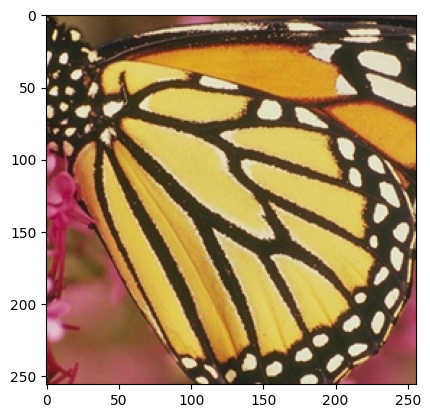

In [141]:
#생성된 이미지 확인
#논문과 동일하게 Set5 데이터셋 사용
hr_img_path = '/content/drive/MyDrive/Set5/Set5/butterfly.png'

hr_img = cv2.imread(hr_img_path)
hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2RGB)
print("img shape: {}".format(hr_img.shape))

plt.imshow(hr_img)

#원본, bicubic, srcnn 비교를 위해 세개의 이미지 확인
hr_img = hr_img.astype('float') / 255
temp_img = cv2.resize(hr_img, dsize=(0,0), fx = 1/upscale_factor, fy = 1/upscale_factor,
                interpolation = cv2.INTER_AREA)
bicubic_img = cv2.resize(temp_img, dsize=(0,0), fx = upscale_factor, fy = upscale_factor,
                interpolation = cv2.INTER_CUBIC)

input_img = bicubic_img[np.newaxis, :]
srcnn_img = SRCNN_Test.predict(input_img)

Text(0.5, 1.0, 'srcnn_img')

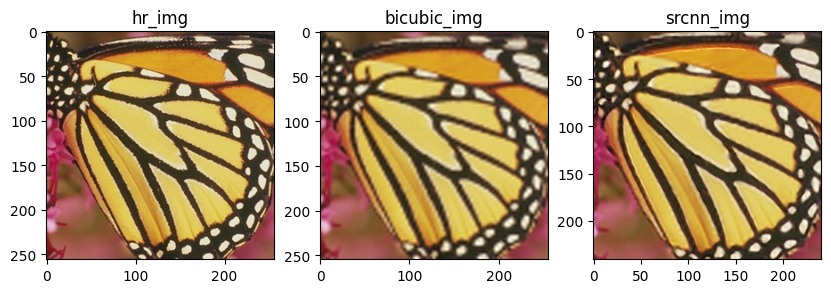

In [142]:
#원본, bicubic, srcnn 비교
fig, axes = plt.subplots(1,3, figsize = (10,5))

axes[0].imshow(hr_img)
axes[1].imshow(bicubic_img)
axes[2].imshow(np.squeeze(srcnn_img))

axes[0].set_title('hr_img')
axes[1].set_title('bicubic_img')
axes[2].set_title('srcnn_img')

In [143]:
print(hr_img.shape)
print(srcnn_img.shape)

(256, 256, 3)
(1, 241, 241, 3)


In [144]:
#성능평가를 위한 PSNR, SSIM 계산
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

hr_img = hr_img.astype('float32') / 255.0
srcnn_img = srcnn_img.astype('float32') / 255.0

#이미지 크기확인
srcnn_height, srcnn_width, _ = srcnn_img.squeeze().shape
hr_height, hr_width, _ = hr_img.squeeze().shape

#이미지 크기 일치시키기
if srcnn_height != hr_height or srcnn_width != hr_width:
    srcnn_img = cv2.resize(srcnn_img.squeeze(), (hr_width, hr_height))

#이미지 0~1사이로 클리핑
srcnn_img = np.clip(srcnn_img, 0.0, 1.0)
hr_img = np.clip(hr_img.squeeze(), 0.0, 1.0)

psnr_value = peak_signal_noise_ratio(hr_img, srcnn_img)
ssim_value = structural_similarity(hr_img, srcnn_img, multichannel=True)

print("PSNR:", psnr_value)
print("SSIM:", ssim_value)

PSNR: 59.886914644478246
SSIM: 0.9987343


<ipython-input-144-bfe464ee75b6>:20: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = structural_similarity(hr_img, srcnn_img, multichannel=True)
